In [1]:
import sys
sys.path.append('/root/autodl-tmp/project')
from data.dtu import DTUDataset
import matplotlib.pyplot as plt
from torchvision import transforms as T

In [2]:
import subprocess
import os

result = subprocess.run('bash -c "source /etc/network_turbo && env | grep proxy"', shell=True, capture_output=True, text=True)
output = result.stdout
for line in output.splitlines():
    if '=' in line:
        var, value = line.split('=', 1)
        os.environ[var] = value

In [3]:
from framwork.ldm.lightning_ldm import PanoOutpaintGenerator
import yaml

In [4]:
config = yaml.load(open("/root/autodl-tmp/project/configs/config_sr_ldm.yaml", "r"), Loader=yaml.FullLoader)
model = PanoOutpaintGenerator.load_from_checkpoint("/root/autodl-tmp/project/checkpoints/last_model-v3.ckpt",config = config)
model = model

In [16]:
from typing import Any, Optional
from pytorch_lightning.utilities.types import STEP_OUTPUT
import yaml
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import numpy as np
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint, Callback, LearningRateMonitor

import sys

In [20]:
import cv2
import torch
import torchvision.transforms as T
path1 = "/root/autodl-tmp/frames/case_0/frame_202.jpg"
path2 = "/root/autodl-tmp/frames/case_0/frame_201.jpg"
path3 = "/root/autodl-tmp/frames/case_0/frame_200.jpg"
img1 = cv2.imread(path1)
img2 = cv2.imread(path2)
img3 = cv2.imread(path3)
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)
img1 = T.ToTensor()(img1).unsqueeze(0)*2-1
img2 = T.ToTensor()(img2).unsqueeze(0)*2-1
img3 = T.ToTensor()(img3).unsqueeze(0)*2-1
dark_imgs = torch.cat([img1, img2, img3])
imgs = torch.cat([img2, img2, img3])
batch = {'dark_imgs':dark_imgs.unsqueeze(0),"mask" : torch.rand(1,1,512,512),"imgs":imgs}

In [7]:
val_data = DTUDataset(root_dir="/root/autodl-fs/dtu2/",split="val",img_wh=(512, 512))
batch = val_data[230]
batch["imgs"] = batch["imgs"].unsqueeze(0)
batch["dark_imgs"] = batch["dark_imgs"].unsqueeze(0)
batch["mask"] = batch["mask"].unsqueeze(0)

In [21]:
image_pred = model.inference(batch)

In [22]:
batch["imgs"].shape

torch.Size([3, 3, 512, 512])

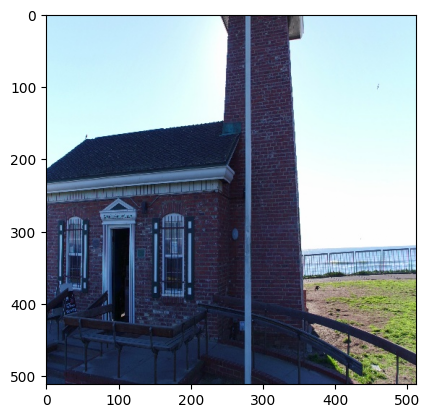

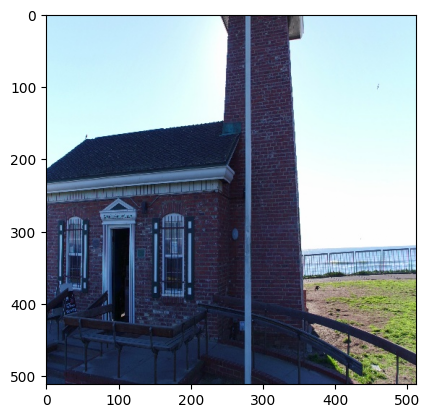

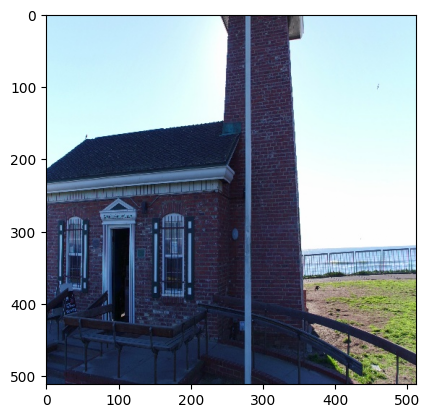

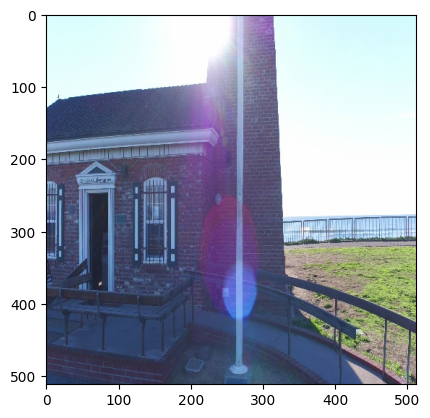

In [23]:
plt.imshow(batch["imgs"][0].permute(1,2,0).cpu().numpy()/2+0.5)
plt.show()
plt.imshow(batch["imgs"][0].permute(1,2,0).cpu().numpy()/2+0.5)
plt.show()
plt.imshow(batch["imgs"][0].permute(1,2,0).cpu().numpy()/2+0.5)
plt.show()
plt.imshow(batch["dark_imgs"][0,0].permute(1,2,0).cpu().numpy()/2+0.5)
plt.show()



In [24]:
import PIL
# save image
img = image_pred[0]
image = PIL.Image.fromarray(img)


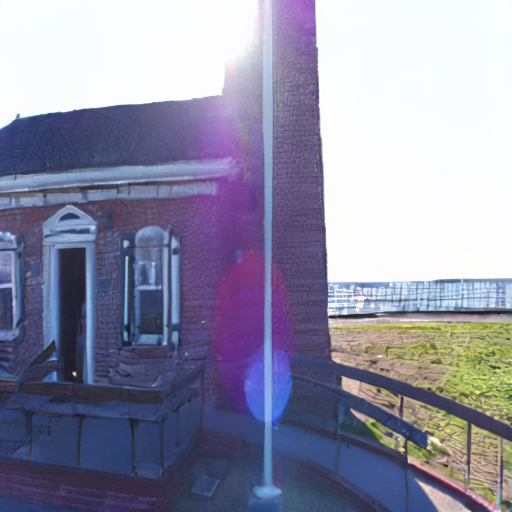

In [25]:
image

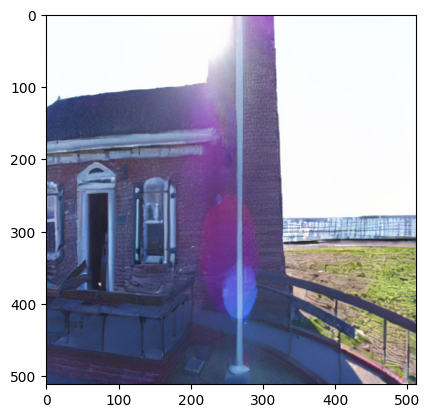

In [26]:
plt.imshow(image_pred[0])


plt.savefig("/root/autodl-tmp/frames/test/frame_292.jpg")

In [73]:
image_change =255*(batch["dark_imgs"][0,0].permute(1,2,0).cpu().numpy()/2+0.5)-255*(batch["dark_imgs"][0,1].permute(1,2,0).cpu().numpy()/2+0.5)
image_change = np.mean(image_change,axis=-1)
threshold = np.sort(np.abs(image_change).reshape(-1))[int(0.8*512*512)]
print(threshold)
mask= np.abs(image_change)>threshold

False


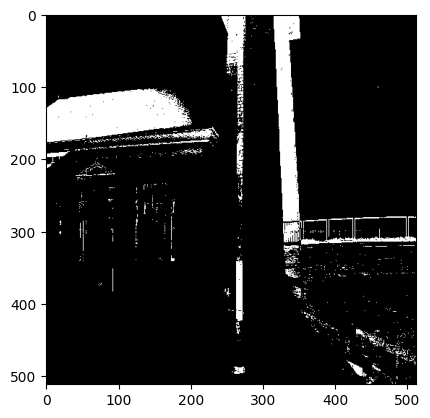

In [74]:
plt.imshow(image_change,cmap="gray")

In [28]:
image_change.min(),image_change.max()

(-202.33333, 222.66667)

In [29]:

image_change = np.clip(image_change,0,1)

# test inpainting model

In [31]:
import sys
sys.path.append('/root/autodl-tmp/ControlNet-3/controledMVSDiffusion')
from test5_CV import new_pano

/root/autodl-tmp
/root/autodl-tmp


ImportError: cannot import name 'get_x_2d' from 'models.modules.utils' (/root/autodl-tmp/project/models/modules/utils.py)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


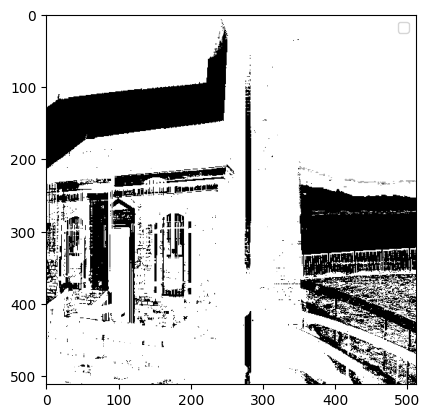

In [108]:

plt.imshow(image_change,cmap="gray")
plt.legend()
plt.show()

In [8]:

from typing import Any, Optional


from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.utilities.types import STEP_OUTPUT


class CallbackLogger(Callback):
    def __init__(self):
        super().__init__()
    def on_train_batch_end(self, trainer: Trainer, pl_module: LightningModule, 
                           outputs: STEP_OUTPUT, batch: Any, batch_idx: int,dataloader_idx) -> None:
        if batch_idx%100==0:
            import cv2
            import torchvision.transforms as T
            path1 = "/root/autodl-tmp/frames/case_0/frame_235.jpg"
            path2 = "/root/autodl-tmp/frames/case_0/frame_234.jpg"
            path3 = "/root/autodl-tmp/frames/case_0/frame_236.jpg"
            img1 = cv2.imread(path1)
            img2 = cv2.imread(path2)
            img3 = cv2.imread(path3)
            img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
            img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
            img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)
            img1 = T.ToTensor()(img1).unsqueeze(0).cuda()*2-1
            img2 = T.ToTensor()(img2).unsqueeze(0).cuda()*2-1
            img3 = T.ToTensor()(img3).unsqueeze(0).cuda()*2-1
            dark_imgs = torch.cat([img1, img2, img3])
            imgs = torch.cat([img2, img2, img3])
            batch = {'dark_imgs':dark_imgs.unsqueeze(0),"mask" : torch.rand(1,1,512,512),"imgs":imgs}
            # model inference
            image_pred = pl_module.inference(batch)
            trainer.logger.experiment.add_images("image_pred_test", image_pred, global_step=trainer.global_step)
            trainer.logger.experiment.add_images("image_gt_test", dark_imgs, global_step=trainer.global_step)
            
    
    def on_validation_batch_end(self, trainer, pl_module, outputs, batch, batch_idx, dataloader_idx):
        dark_imgs = outputs["dark_imgs"]
        gt_imgs = outputs["gt_imgs"]
        pred_imgs = outputs["pred_imgs"]
        mask = outputs["mask"].repeat(1,3,1,1)
        ## use logger to log images
        dark_imgs = np.transpose(dark_imgs,(0,3,1,2))
        gt_imgs = np.transpose(gt_imgs,(0,3,1,2))
        pred_imgs = np.transpose(pred_imgs,(0,3,1,2))
        
       
        
        
        


        trainer.logger.experiment.add_images("dark_imgs", dark_imgs, global_step=trainer.global_step)
        trainer.logger.experiment.add_images("gt_imgs", gt_imgs, global_step=trainer.global_step)
        trainer.logger.experiment.add_images("pred_imgs", pred_imgs, global_step=trainer.global_step)
        #trainer.logger.experiment.add_images("mask", mask, global_step=trainer.global_step)
        print("add images")


In [7]:

import torch
data_train = DTUDataset(root_dir="/root/autodl-fs/dtu2/",
                        split="train",
                        img_wh=(512, 512),
                        # train_test=True,
                        
                        )
class datawarper:
        def __init__(self,dataset):
                self.dataset=dataset
                
                        

        def __getitem__(self,index):
                try:
                                
                        return self.dataset[index]
                except Exception as e:
                        print(e)
                        return self.__getitem__(index+1)
                                
        def __len__(self):
                return len(self.dataset)
        
datasets_dtu = data_train
train_loader = torch.utils.data.DataLoader(
                datasets_dtu, batch_size=10, shuffle=True, num_workers=0,
        )

val_data = DTUDataset(root_dir="/root/autodl-fs/dtu2/",split="val",img_wh=(512, 512))
data_val =val_data
        # only sample 10 batches for validation
        

val_loader = torch.utils.data.DataLoader(
data_val, batch_size=1, shuffle=True, num_workers=0)
lr_monitor = LearningRateMonitor(logging_interval='step')



In [8]:

        
config = yaml.load(open("/root/autodl-tmp/project/configs/config_sr_ldm.yaml", "r"), Loader=yaml.FullLoader)

        

        # Step 2: Create the Trainer
trainer_config = config["Trainer"].get("trainer", {})
trainer_config["strategy"]=None
checkpoint_config = config["Trainer"].get("checkpoint", {})
        

        # Create callbacks
        
        
model = PanoOutpaintGenerator(config)





                # Create logger
logger = pl.loggers.TensorBoardLogger(**config["Trainer"].get("logger", {}))

trainer = pl.Trainer(
                **trainer_config,
               
                logger=logger, max_epochs=400,limit_val_batches=10,
                #resume_from_checkpoint="/root/autodl-tmp/project/checkpoints/ldm.ckpt"
                
        )
        # set batch size automatically
trainer.fit(model, train_loader, train_loader)

/root/miniconda3/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:849: UserWarning: You requested multiple GPUs but did not specify a backend, e.g. `Trainer(strategy="dp"|"ddp"|"ddp2")`. Setting `strategy="ddp_spawn"` for you.
  rank_zero_warn(
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/2
initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/2
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 2 processes
----------------------------------------------------------------------------------------------------


  | Name  | Type         | Params
---------------------------------------
0 | vae   | VQModel      | 55.3 M
1

Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]

/root/miniconda3/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:56: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 10. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
/root/miniconda3/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:685: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


: 

In [ ]:

optmizer = model.configure_optimizers()["optimizer"]
def lot(data, loss,on_step=True,on_epoch=True,prog_bar=True,logger=True):
    return {"loss":loss}
model.log = lot
for data in train_loader:
    for key in data.keys():
        try:
            data[key]=data[key].cuda()
        except:
            pass
    optmizer.zero_grad()
    loss = model.training_step(data,0)
    loss.backward()
    optmizer.step()
    print(loss.isnan())

/root/miniconda3/lib/python3.8/site-packages/diffusers/configuration_utils.py:139: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDIMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDIMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(F

KeyboardInterrupt: 